In [ ]:
# Weather Trend Forecasting Analysis

## PM Accelerator Mission

**PM Accelerator Mission:**
By making industry-leading tools and education available to individuals from all backgrounds, we level the playing field for future PM leaders. This is the PM Accelerator motto, as we grant aspiring and experienced PMs what they need most – Access. We introduce you to industry leaders, surround you with the right PM ecosystem, and discover the new world of AI product management skills.


## Project Overview
This project analyzes global weather trends using data from the Global Weather Repository. It includes:
- **Data Cleaning & Preprocessing:** Handling missing values and date formatting.
- **Exploratory Data Analysis (EDA):** Visualizing trends in temperature and precipitation.
- **Forecasting Models:** Building ARIMA and Prophet models and creating an ensemble forecast.
- **Advanced Analyses:**
  - Climate Analysis: Studying long-term climate patterns by region.
  - Environmental Impact: Analyzing air quality correlations with weather.
  - Feature Importance: Evaluating which factors influence temperature.
  - Spatial Analysis: Visualizing weather data geographically.
  - Geographical Patterns: Exploring differences in weather across countries and continents.

This report documents our methodology, findings, and insights, and is intended for submission as part of the project requirements.

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/GlobalWeatherRepository.csv")


print(df.head())
print(df.info())


df.fillna(method='ffill', inplace=True)


       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1715849100  2024-05-16 13:15                 26.6   
1          1715849100  2024-05-16 10:45                 19.0   
2          1715849100  2024-05-16 09:45                 23.0   
3          1715849100  2024-05-16 10:45                  6.3   
4          1715849100  2024-05-16 09:45                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   
1                    66.2  Partly cloudy

<ipython-input-4-25908d394e79>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


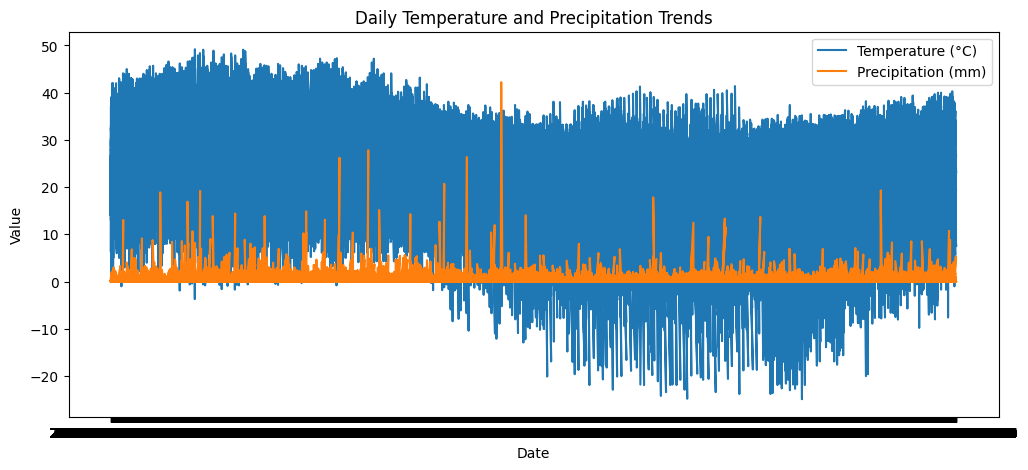

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df['last_updated'], df['temperature_celsius'], label='Temperature (°C)')
plt.plot(df['last_updated'], df['precip_mm'], label='Precipitation (mm)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Daily Temperature and Precipitation Trends')
plt.legend()
plt.show()

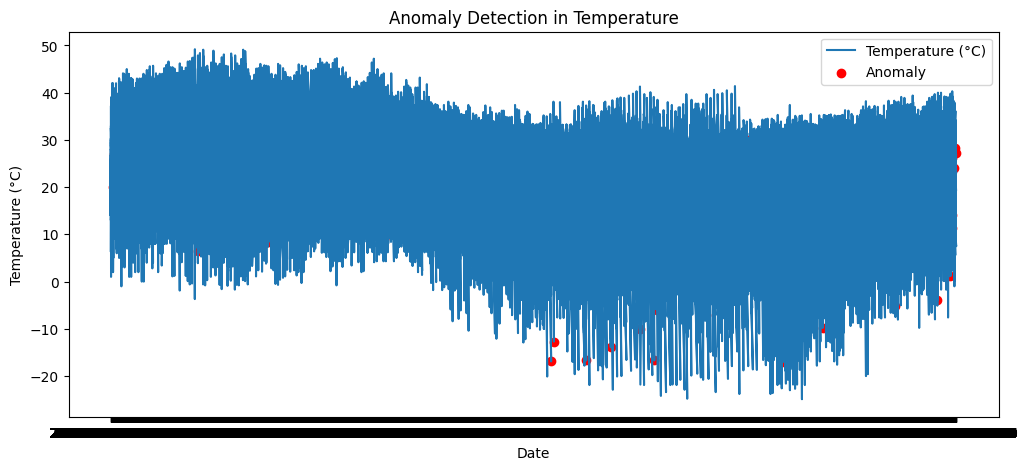

In [6]:
from sklearn.ensemble import IsolationForest


features = df[['temperature_celsius', 'precip_mm']]
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = iso_forest.fit_predict(features)
anomalies = df[df['anomaly'] == -1]


plt.figure(figsize=(12, 5))
plt.plot(df['last_updated'], df['temperature_celsius'], label='Temperature (°C)')
plt.scatter(anomalies['last_updated'], anomalies['temperature_celsius'], color='r', label='Anomaly')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Anomaly Detection in Temperature')
plt.legend()
plt.show()

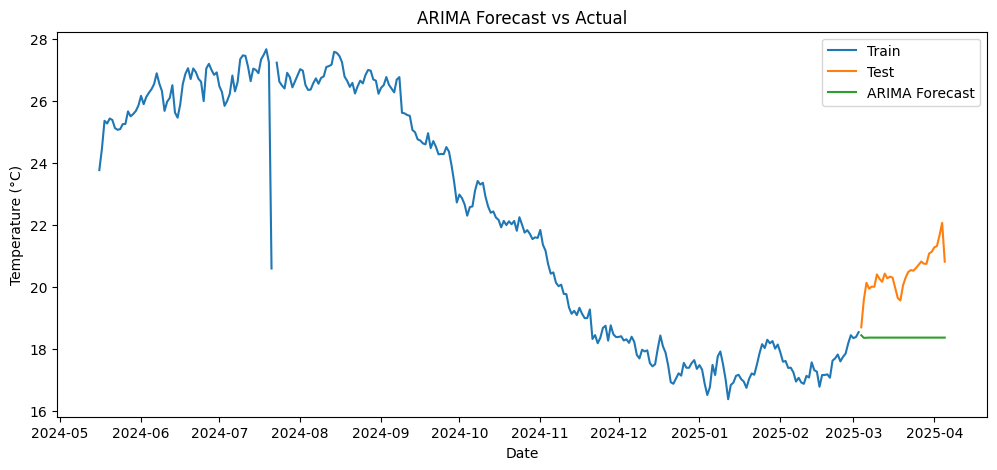

In [8]:
from statsmodels.tsa.arima.model import ARIMA


df_arima = df.sort_values('last_updated').set_index('last_updated')


df_arima.index = pd.to_datetime(df_arima.index)

temperature_ts = df_arima['temperature_celsius'].resample('D').mean()

split_index = int(0.9 * len(temperature_ts))
train, test = temperature_ts.iloc[:split_index], temperature_ts.iloc[split_index:]


model_arima = ARIMA(train, order=(2, 1, 2))
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=len(test))


plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_0c8hvr_/rp8qkyjq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_0c8hvr_/g7n83y59.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42528', 'data', 'file=/tmp/tmp_0c8hvr_/rp8qkyjq.json', 'init=/tmp/tmp_0c8hvr_/g7n83y59.json', 'output', 'file=/tmp/tmp_0c8hvr_/prophet_modelgoykn8gc/prophet_model-20250405182219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:22:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


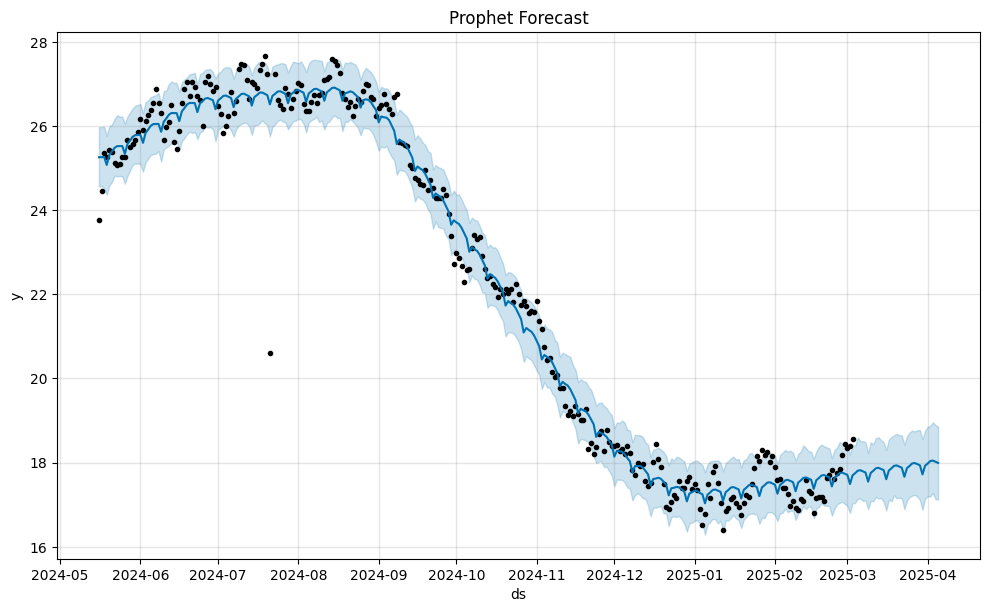

In [9]:
from prophet import Prophet


prophet_df = temperature_ts.reset_index().rename(columns={'last_updated': 'ds', 'temperature_celsius': 'y'})
train_prophet = prophet_df.iloc[:split_index]
test_prophet = prophet_df.iloc[split_index:]


m = Prophet()
m.fit(train_prophet)

future = m.make_future_dataframe(periods=len(test_prophet), freq='D')
forecast_prophet = m.predict(future)


fig1 = m.plot(forecast_prophet)
plt.title('Prophet Forecast')
plt.show()

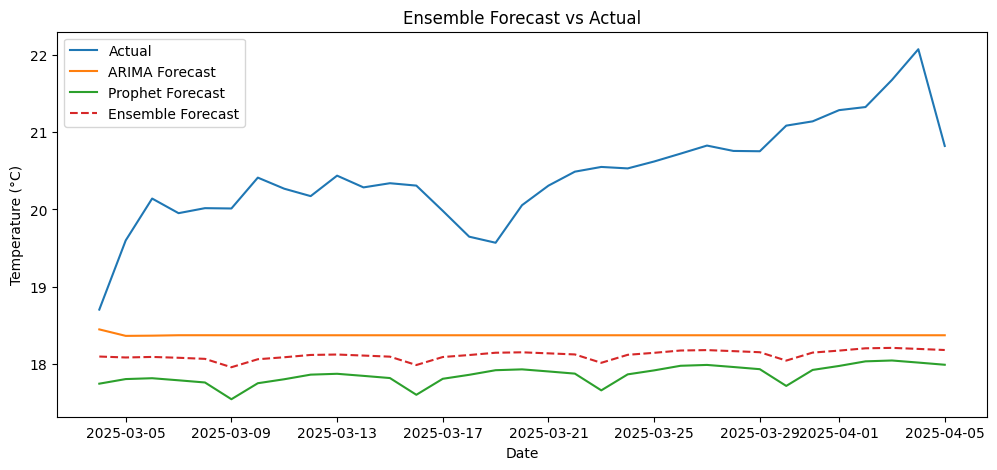

In [10]:

prophet_forecast = forecast_prophet[['ds', 'yhat']].set_index('ds').loc[test.index]
ensemble_forecast = (forecast_arima + prophet_forecast['yhat']) / 2

plt.figure(figsize=(12, 5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast')
plt.plot(test.index, prophet_forecast['yhat'], label='Prophet Forecast')
plt.plot(test.index, ensemble_forecast, label='Ensemble Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Ensemble Forecast vs Actual')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error
import math

def rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

print("ARIMA RMSE:", rmse(test, forecast_arima))
print("Prophet RMSE:", rmse(test, prophet_forecast['yhat']))
print("Ensemble RMSE:", rmse(test, ensemble_forecast))

ARIMA RMSE: 2.170239407088663
Prophet RMSE: 2.65208193354984
Ensemble RMSE: 2.408706943694686


Countries available: ['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso'
 'Burundi' 'Madagascar' 'Cape Verde' 'Cambodia' 'Cameroon' 'Canada'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Comoros' 'Congo'
 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czech Republic'
 'Democratic Republic of Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Swaziland' 'Ethiopia' 'Fiji Islands' 'Finland'
 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Vatican City'
 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq'
 'Ireland' 'Israel' 'Italy' 'Jamaica' 'J

<ipython-input-14-221997ca0a6a>:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_temp = df_country['temperature_celsius'].resample('M').mean()


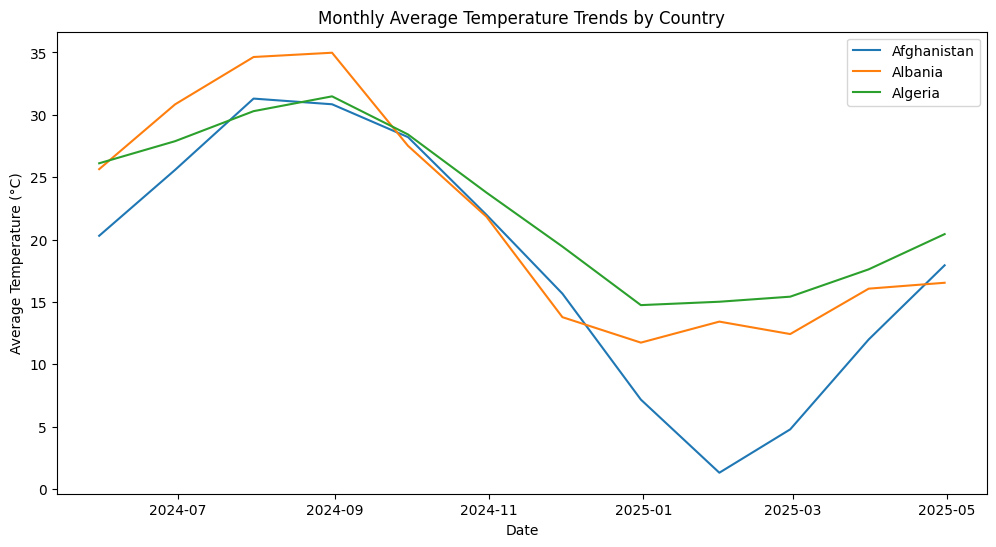

In [14]:
import pandas as pd
import matplotlib.pyplot as plt


df_climate = df.copy()
df_climate['last_updated'] = pd.to_datetime(df_climate['last_updated'])
df_climate.set_index('last_updated', inplace=True)


countries = df_climate['country'].unique()
print("Countries available:", countries)


selected_countries = countries[:3]

plt.figure(figsize=(12, 6))
for country in selected_countries:
    df_country = df_climate[df_climate['country'] == country]

    monthly_temp = df_country['temperature_celsius'].resample('M').mean()
    plt.plot(monthly_temp.index, monthly_temp, label=country)

plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.title('Monthly Average Temperature Trends by Country')
plt.legend()
plt.show()

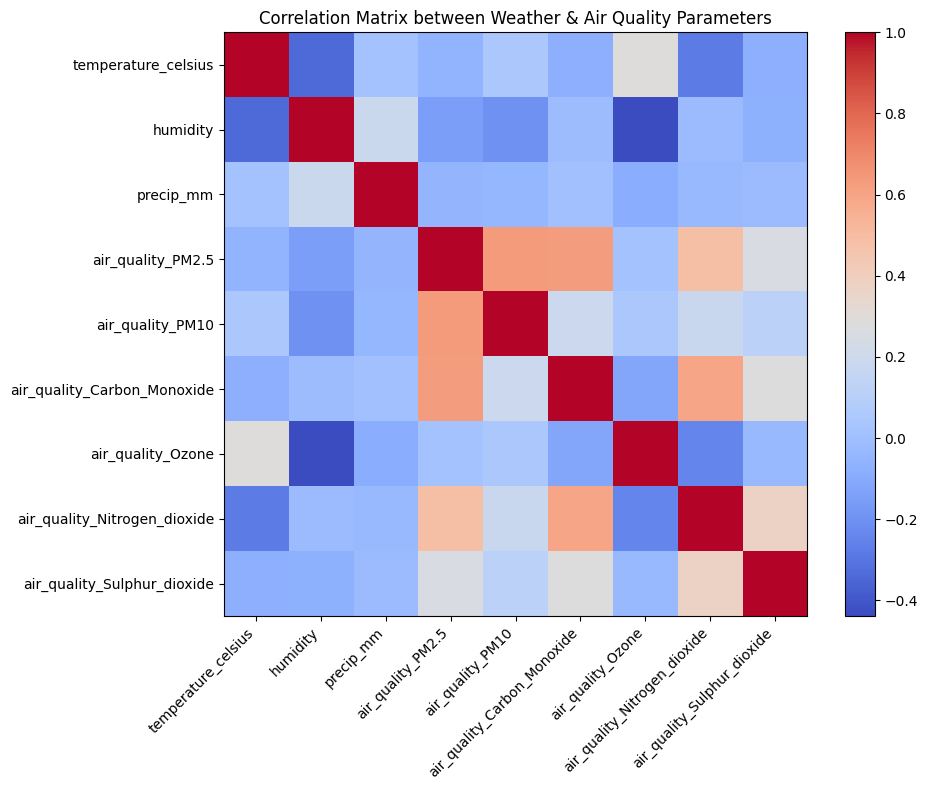

Correlation Matrix:
                              temperature_celsius  humidity  precip_mm  \
temperature_celsius                      1.000000 -0.339447   0.020389   
humidity                                -0.339447  1.000000   0.186031   
precip_mm                                0.020389  0.186031   1.000000   
air_quality_PM2.5                       -0.051845 -0.146594  -0.050076   
air_quality_PM10                         0.045453 -0.201462  -0.042801   
air_quality_Carbon_Monoxide             -0.077843 -0.016084   0.008477   
air_quality_Ozone                        0.282256 -0.438371  -0.087457   
air_quality_Nitrogen_dioxide            -0.280034 -0.018606  -0.028750   
air_quality_Sulphur_dioxide             -0.078596 -0.068740  -0.021334   

                              air_quality_PM2.5  air_quality_PM10  \
temperature_celsius                   -0.051845          0.045453   
humidity                              -0.146594         -0.201462   
precip_mm                       

In [15]:
import matplotlib.pyplot as plt


columns_for_corr = [
    'temperature_celsius', 'humidity', 'precip_mm',
    'air_quality_PM2.5', 'air_quality_PM10',
    'air_quality_Carbon_Monoxide', 'air_quality_Ozone',
    'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide'
]


df_corr = df[columns_for_corr].dropna()


corr_matrix = df_corr.corr()


plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Correlation Matrix between Weather & Air Quality Parameters')
plt.tight_layout()
plt.show()

print("Correlation Matrix:")
print(corr_matrix)

Feature Importances:
pressure_mb    0.447689
humidity       0.307625
wind_mph       0.182494
precip_mm      0.062192
dtype: float64


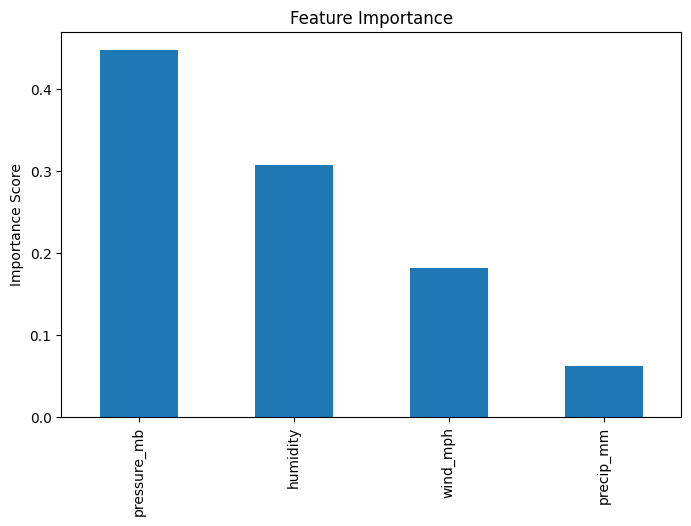

In [12]:
from sklearn.ensemble import RandomForestRegressor


feature_cols = ['precip_mm', 'humidity', 'wind_mph', 'pressure_mb']
X = df_arima[feature_cols]
y = df_arima['temperature_celsius']

rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
print("Feature Importances:")
print(feat_imp)

plt.figure(figsize=(8, 5))
feat_imp.plot(kind='bar', title='Feature Importance')
plt.ylabel('Importance Score')
plt.show()

In [13]:
import folium


map_obj = folium.Map(location=[20, 0], zoom_start=2)


for idx, row in df.drop_duplicates(subset=['location_name']).iterrows():
    if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=3,
            popup=f"{row['location_name']} - Temp: {row['temperature_celsius']:.2f}°C",
            color='blue',
            fill=True
        ).add_to(map_obj)


map_obj.save("weather_map.html")
print("Spatial map saved as weather_map.html")

Spatial map saved as weather_map.html
